XI.9.2 (б) Получите численное решение следующих нелинейных краевых задач:
$$ y'' + \frac{0.5}{1 - 0.5 y} y'^2 = 0, ~~ 0 < x \leq 1 $$

$$ y(0) = y_0, ~~ y(1) = 0, $$

$ y_0 = 0.25; 0.5; 1; 1.5; 1.8; 1.9; 1.95; $

Решение:
$$ y'' + \frac{0.5}{1 - 0.5 y} y'^2 = 0, ~~ 0 < x \leq 1 $$

$$
\begin{cases}
\psi' = \varphi \\
\varphi' = - \frac{0.5}{1 - 0.5 \psi} \varphi ^ 2
\end{cases} 
$$

In [78]:
import pandas as pd
import sympy as smp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

import math

import scipy
from scipy import integrate
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.optimize import newton
from scipy.optimize import bisect


In [79]:
def plot_wavefunction(fig, title_string, x_arr, num_arr, axis_list, path):
    # clear plot
    plt.cla() # clear axis
    plt.clf() # clear figure

    plt.plot(x_arr, num_arr, 'b:', linewidth = 4, label = r"$y(x)$")

    plt.ylabel(r"$y$", fontsize = 16)
    plt.xlabel(r'$x$', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 'small')

    plt.axis(axis_list)
    plt.title(title_string)
    plt.grid()

    fig.savefig(path + title_string + ".png")

In [80]:
def RungeKutta4(f, x, y_0, params=[]):

    n = len(x)
    res = np.zeros(shape = (n, len(y_0)))
    res[0] = y_0

    for i in range(n - 1):
        h = x[i + 1] - x[i]
        
        f_1 = f(res[i]                  , x[i],             params)
        f_2 = f(res[i] + 1 / 2 * h * f_1, x[i] + 1 / 2 * h, params)
        f_3 = f(res[i] + 1 / 2 * h * f_2, x[i] + 1 / 2 * h, params)
        f_4 = f(res[i] +         h * f_3, x[i] +         h, params)

        res[i + 1] = res[i] + h * (1 / 6 * f_1 + 
                                   2 / 6 * f_2 + 
                                   2 / 6 * f_3 + 
                                   1 / 6 * f_4)
        
    return res

def findZeros(rightbound_vals):
    return np.where(np.diff(np.signbit(rightbound_vals)))[0]

""" Shooting method: find zeroes of function func for energies in alpha_arr. 
   
    func      : Schroedinger equation to solve.
    psi0      : initial conditions on left side, can be array.
    alpha_arr : array of parameter values : find possible zeroes.
"""
def shoot(func, x, psi0, params : list, alpha_arr):


    psi_rightb = []

    for i in range(len(alpha_arr)):
        params.insert(0, alpha_arr[i])
        psi = RungeKutta4(func, x, psi0[i], params)
        params.pop(0)
        psi_rightb.append(psi[-1][0])

    return np.asarray(psi_rightb)

def shootRK4(alpha, func, x, psi0, params : list):

    params.insert(0, alpha)
    psi0[1] = alpha
    psi = RungeKutta4(func, x, psi0, params)
    params.pop(0)

    return psi[-1][0]

eps = 1e-3

def optimizeAlphaNewton(func, x, psi0, params : list, alpha_arr):
    
    shoot_try = shoot(func, x, psi0, params, alpha_arr)
    crossings = findZeros(shoot_try)
    alpha_list = []

    for cross in crossings:
        alpha_list.append(newton(shootRK4, alpha_arr[cross], args = (func, x, psi0[cross], params), tol = eps))
                                                                          
    return np.asarray(alpha_list)

In [81]:
def F(y, x, params : list):

    psi, phi = y
    
    dphidx = [phi, - 0.5 / (1 - 0.5 * psi) * phi ** 2]

    return np.asarray(dphidx)

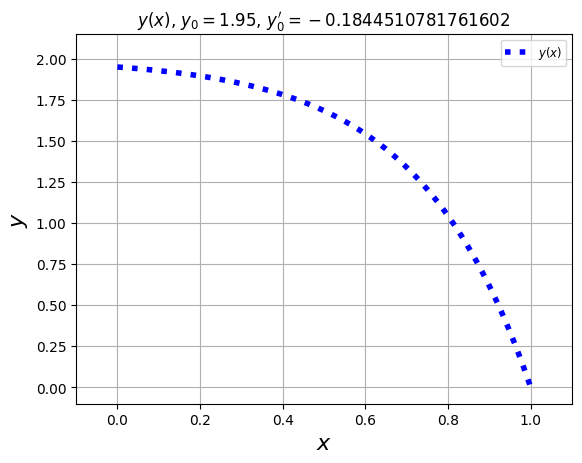

In [82]:
def shooting_method(psi_init, h_):
    """ Shooting method

        Returns the numerical solution as arrays.
    """

    x_arr     = np.arange(0.0, 1.0 + h_, h_)
    phi_0_arr = np.arange(-1.0, 0, 0.05)

    psi_init_arr = np.zeros(shape = (len(phi_0_arr), len(psi_init)))

    for i in range(len(phi_0_arr)):
        psi_init_arr[i][0] = psi_init[0]
        psi_init_arr[i][1] = phi_0_arr[i]

    eigPhi = optimizeAlphaNewton(F, x_arr, psi_init_arr, [], phi_0_arr)
                          
    outlist = []

    for EI in eigPhi:
        psi_init[1] = EI
        out = RungeKutta4(F, x_arr, psi_init, [EI])
        outlist.append(out[:, 0])
    
    out_arr = np.asarray(outlist)

    return x_arr, out_arr, eigPhi

y_0 = np.asarray([0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95])
h_ = 1.0 / 1000.0 # step size for range arrays

fig = plt.figure()

for i in y_0:
    psi_init = np.asarray([i, 1.0])

    x, y_n, eig = shooting_method(psi_init, h_)

    for j in range(len(eig)):
        plot_wavefunction(fig, r"$y(x)$, $y_0 = {}$, $y_0' = {}$".format(i, eig[j]), x, y_n[j, :], [-0.1, 1.1, -0.1, i + 0.2], "plots_shooting/")

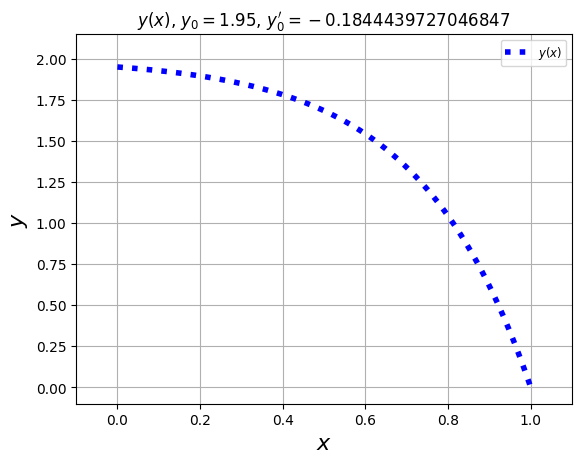

In [85]:
def quasi_linearization(psi_init, h_):
    x_arr = np.arange(0.0, 1.0 + h_, h_)
    phi_0_arr = np.linspace(-1, 0, int(1/0.05)) 
    solutions = []
    eig_vals = []
    for phi_0 in phi_0_arr:
        # Optimize phi_0 using bisect method
        optimized_phi_0 = bisect(lambda phi: RungeKutta4(F, x_arr, [psi_init[0], phi])[-1][0], -1, 0)
        y_n = RungeKutta4(F, x_arr, [psi_init[0], optimized_phi_0])
        if np.abs(y_n[-1][0]) < 1e-3:  
            solutions.append(y_n[:, 0]) 
            eig_vals.append(optimized_phi_0)
    return x_arr, np.array(solutions), np.array(eig_vals)

y_0 = np.asarray([0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95])
h_ = 1.0 / 1000.0 # step size for range arrays

fig = plt.figure()

for i in y_0:
    psi_init = np.asarray([i, 1.0])
    x, y_n, eig = quasi_linearization(psi_init, h_)
    for j in range(len(eig)):
        plot_wavefunction(fig, r"$y(x)$, $y_0 = {}$, $y_0' = {}$".format(i, eig[j]), x, y_n[j, :], [-0.1, 1.1, -0.1, i + 0.2], "plots_quazi/")